# Estimation of neuronal tuning curves using the Poisson Generalized Additive Model (PGAM)
This code enables to construction and fitting of a Poisson Generalized Additive Model (PGAM) to estimate neuronal tuning curves from spike count data. The tuning curves are constructed using a basis of B-splines with knots and order specified by the user in the ``make_config`` function. Alpha criterion is set by the user to determine the significance of the estimated tuning curves. The code also includes a function to plot the estimated tuning curves.

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import time
from pathlib import Path
import yaml
import statsmodels.api as sm
from core import *


# PGAM function from Eduardo Bolzani's repository
import GAM_library as gl
import gam_data_handlers as gdh
from post_processing import postprocess_results

# Setting the matplotlib backend
import matplotlib
#matplotlib.use('agg')

Defining data storage and save directories, mice and sessions to analyze, and some other global variables and model parameters.

In [2]:
# Defining directories where the data is stored and where the results will be saved
root_data_dir = Path("D:/clickbait-mmz")
root_save_dir = Path("C:/Users/smearlab/clickbait-mmz/figures/testing_6_11")
os.makedirs(root_save_dir, exist_ok=True)

# Defining the mice and session labels to analyze
mice = ['6002']
sessions = ['6']

# Defining the window size and step for computing spike rates in seconds
window_size = 1
step_size = 1

# Deciding which units to use from the manual spike curation (Phy2) output: choices = [good, good/mua, mua]
use_units = 'good'

# Define the order for the B-spline basis functions
order = 4

# Define the fraction of data to hold out for evaluation
frac_eval = 0.1

# Define the alpha criterion for the model
alpha = 1e-5

Making the configuration file for the PGAM model

In [3]:

def make_config(order, window_size, save_path):

    # make the knots
    knots_x = np.hstack(([-75]*(order-1), np.linspace(-75,75,5),[75]*(order-1)))
    knots_y = np.hstack(([-150]*(order-1), np.linspace(-150,150,5),[150]*(order-1)))
    knots_v_x = np.hstack(([-10]*(order-1), np.linspace(-10,10,5),[10]*(order-1)))
    knots_v_y = np.hstack(([-10]*(order-1), np.linspace(-10,10,5),[10]*(order-1)))
    knots_sns = np.hstack(([2]*(order-1), np.linspace(2,12,5),[12]*(order-1)))
    knots_latency = np.hstack(([0]*(order-1), np.linspace(0,1,5),[1.25]*(order-1)))
    knots_phase = np.linspace(0, 2*np.pi, 5)
    knots_speed = np.hstack(([0]*(order-1), np.linspace(0,10,5),[10]*(order-1)))

    # convert to float
    knots_x = [float(k) for k in knots_x]
    knots_y = [float(k) for k in knots_y]
    knots_v_x = [float(k) for k in knots_v_x]
    knots_v_y = [float(k) for k in knots_v_y]
    knots_sns = [float(k) for k in knots_sns]
    knots_latency = [float(k) for k in knots_latency]
    knots_phase = [float(k) for k in knots_phase]
    knots_speed = [float(k) for k in knots_speed]

    # create the config dictionary
    cov_dict = {
        'position_x' : {
            'lam':10, 
            'penalty_type': 'der', 
            'der': 2, 
            'knots': knots_x,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [False],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size
        },

        'position_y' : {
            'lam':10, 
            'penalty_type': 'der', 
            'der': 2, 
            'knots': knots_y,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [False],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size
        },
        'velocity_x' : {
            'lam':10,
            'penalty_type': 'der',
            'der': 2,
            'knots': knots_v_x,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [False],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size
        },
        'velocity_y' : {
            'lam':10,
            'penalty_type': 'der',
            'der': 2,
            'knots': knots_v_y,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [False],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size
        },

        'sns' : {
            'lam':10, 
            'penalty_type': 'der', 
            'der': 2, 
            'knots': knots_sns,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [False],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size 
        },
        'latency' : {
            'lam':10, 
            'penalty_type': 'der', 
            'der': 2, 
            'knots': knots_latency,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [False],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size 
        },
        'phase' : {
            'lam':10, 
            'penalty_type': 'der', 
            'der': 2, 
            'knots': knots_phase,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [True],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size 
        },
        'speed': {
            'lam':10, 
            'penalty_type': 'der', 
            'der': 2, 
            'knots': knots_speed,
            'order':order,
            'is_temporal_kernel': False,
            'is_cyclic': [False],
            'knots_num': np.nan,
            'kernel_length': np.nan,
            'kernel_direction': np.nan,
            'samp_period':window_size
        },

        'click' : {
            'lam':10, 
            'penalty_type': 'der', 
            'der': 2, 
            'knots': np.nan,
            'order':order,
            'is_temporal_kernel': True,
            'is_cyclic': [False],
            'knots_num': 8,
            'kernel_length': 101,
            'kernel_direction': 0,
            'samp_period':window_size
        }
    }

    # save the yaml config
    with open(os.path.join(save_path, 'config.yml'), 'w') as outfile:
        yaml.dump(cov_dict, outfile, default_flow_style=False)

make_config(order, window_size, root_save_dir)


In [ ]:
# Loading the configuration file for the session
with open(os.path.join(root_save_dir, 'config.yml'), 'r') as file:
    config = yaml.safe_load(file)


for mouse in mice:
    for session in sessions:
        
        save_dir = root_save_dir / mouse / session

        # Preprocessing the data to get spike counts, behavioral variables and names, trial IDs, neuron names, and neuron info from manual curation
        counts, variables, variable_names, trial_ids, neu_names, neu_info = preprocess(root_data_dir, save_dir, mouse, session, window_size, step_size, use_units)

        # create the train and eval sets. Eval are not yet used, but will be used in the future for model evaluation
        train_trials = trial_ids % (np.round(1/frac_eval)) != 0
        eval_trials = ~train_trials

        # Looping through each neuron to fit the model
        for fit_num, neuron_num in enumerate(neu_names):
            start = time.time()
            
            sm_handler = gdh.smooths_handler()
            for var in config.keys():

                # check if var is a neuron or a variable
                if var in variable_names:
                    idx = variable_names.index(var)
                    x_var = variables[idx]
                elif var in neu_names:
                    x_var = np.squeeze(counts[:, np.array(neu_names) == var])
                else:
                    raise ValueError('Variable "%s" not found in the input data!'%var)
                

                raw_knots = config[var]['knots']
                if raw_knots is None or (isinstance(raw_knots, float) and np.isnan(raw_knots)):
                    knots = None
                elif isinstance(raw_knots[0], (list, np.ndarray)):
                    knots = [np.array(k) for k in raw_knots]
                else:
                    knots = [np.array(raw_knots)]  # single 1D variable

                
                # rename the variable as spike hist if the input is the spike counts of the neuron we are fitting
                if var == neuron_num:
                    label = 'spike_hist'
                else:
                    label = var
                    
                # Wrap the variable in a list if it is 1D or 2D
                if x_var.ndim == 2 and x_var.shape[1] == 2:
                    x_var = [x_var[:, 0], x_var[:, 1]]  # list of two 1D arrays for 2D variables
                else:
                    x_var = [x_var]  # still wrap 1D variables in a list

                # Add the variable to the smooth handler object 
                sm_handler.add_smooth(
                    label, 
                    x_var, 
                    knots=knots, 
                    ord=config[var]['order'], 
                    is_temporal_kernel=config[var]['is_temporal_kernel'],
                    trial_idx=trial_ids, 
                    is_cyclic=config[var]['is_cyclic'], 
                    penalty_type=config[var]['penalty_type'], 
                    der=config[var]['der'],
                    lam=config[var]['lam'],
                    knots_num=config[var]['knots_num'], 
                    kernel_length=config[var]['kernel_length'],
                    kernel_direction=config[var]['kernel_direction'],
                    time_bin=config[var]['samp_period']
                )
            
            # Set the link function (log link) and the distribution family (Poisson) for the spike counts
            link = sm.genmod.families.links.log()
            poissFam = sm.genmod.families.Poisson(link=link)
            spk_counts = np.squeeze(counts[:, fit_num])

            # Create the PGAM model
            pgam = gl.general_additive_model(sm_handler, sm_handler.smooths_var, spk_counts, poissFam)
            print(f'\n\nFitting neuron {neuron_num} ({fit_num+1}/{len(neu_names)})', flush=True)
            full, reduced = pgam.fit_full_and_reduced(
                    sm_handler.smooths_var, 
                    th_pval=alpha,
                    max_iter=1e2,
                    use_dgcv=True,
                    trial_num_vec=trial_ids,
                    ilter_trials=train_trials
            )
            print('\nMinimal subset of variables driving the activity:', flush=True)
            if reduced is None:
                print('No significant variables found')
                var_list = []
            else:
                var_list = reduced.var_list
                print(var_list, flush=True)

            # saving the list of variables driving the activity
            np.savez(os.path.join(save_dir, f'{neuron_num}_var_list.npz'), var_list=var_list, unit_info=neu_info[neuron_num])
            



            # This only works when fitting 1D variables!
            post_process = True
            if post_process:
                print('\npost-process fit results...')
                res = postprocess_results(neuron_num, spk_counts, full, reduced, train_trials,
                                sm_handler, poissFam, trial_ids, var_zscore_par=None, info_save=neu_info, bins=100)
                
  

                
                np.savez(os.path.join(save_dir, f'{neuron_num}_results.npz'), results = res)
                make_plots = True
                if make_plots:
                    # plot tuning functions
                    plt.figure(figsize=(18,8))
                    plt.title('Tuning functions for neuron %s'%neuron_num)
                    nk = len(res['variable'])
                    for k in range(nk):

                        print('Plotting tuning function for variable %s'%res['variable'][k])

                        #skip click
                        if res['variable'][k] == 'click':
                            continue

                        plt.subplot(2,nk,k+1)
                        plt.title('log-space %s'%res['variable'][k])
                        x_kernel = res['x_kernel'][k].flatten()
                        y_kernel = res['y_kernel'][k].flatten()
                        ypCI_kernel = res['y_kernel_pCI'][k]
                        ymCI_kernel = res['y_kernel_mCI'][k]
                        plt.plot(x_kernel, y_kernel, color='r')
                        plt.fill_between(x_kernel, ymCI_kernel, ypCI_kernel, color='r', alpha=0.3)
                        x_firing = res['x_rate_Hz'][k][0].flatten()
                        y_firing_model = res['y_rate_Hz_model'][k].flatten()
                        y_firing_raw = res['y_rate_Hz_raw'][k].flatten()
                        plt.subplot(2,nk,k+nk+1)
                        plt.title('rate-space %s'%res['variable'][k])
                        plt.plot(x_firing, y_firing_raw, color='grey',label='raw')
                        plt.plot(x_firing, y_firing_model, color='r',label='model')
                        if k == 0:
                            plt.legend()
                        plt.tight_layout()
                    plt.savefig(os.path.join(save_dir, f'{neuron_num}_tuning.png'))
                    plt.close()
                    print('Neuron %s done in %.2f seconds'%(neuron_num, time.time()-start))
                    print('\n\n')



                




        
        

    Unit 1  Unit 2  Unit 3  Unit 4  Unit 5  Unit 6  Unit 7  Unit 8  Unit 9  \
16     3.0     1.0    23.0     0.0     0.0    13.0     0.0     0.0     7.0   
17     3.0     0.0    10.0     0.0     0.0     7.0     0.0     0.0    10.0   
18    23.0     0.0     7.0     0.0     0.0     3.0     0.0     0.0     5.0   
19    11.0     0.0    11.0     0.0     0.0     4.0     0.0     1.0     7.0   
20     2.0     1.0    16.0     0.0     0.0    11.0     0.0     0.0     9.0   

    Unit 10  ...       v_x       v_y     speed  time  reward_state  trial_id  \
16     13.0  ... -3.751843 -1.650618  4.098886  16.0           0.0       1.0   
17      7.0  ...  0.486737  0.777193  0.917029  17.0           0.0       1.0   
18      5.0  ... -0.888582 -0.725199  2.046549  18.0           0.0       1.0   
19     13.0  ... -2.263902 -2.227592  3.176069  19.0           0.0       1.0   
20     10.0  ... -0.771197 -0.876070  1.167152  20.0           0.0       1.0   

    click       sns  latency     phase  
16    1.0

c:\Users\smearlab\analysis_code\PGAM\post_processing.py:433: RuntimeWarning: invalid value encountered in true_divide
  tuning = tuning / tot_s_vec
c:\Users\smearlab\analysis_code\PGAM\post_processing.py:434: RuntimeWarning: invalid value encountered in true_divide
  sc_based_tuning = sc_based_tuning / tot_s_vec


processing:  phase
processing:  position_x
processing:  position_y
processing:  sns
processing:  speed
processing:  velocity_x
processing:  velocity_y
Plotting tuning function for variable click
Plotting tuning function for variable latency


ValueError: no field of name model_rate_Hz

In [9]:
res = r"C:\Users\smearlab\clickbait-mmz\figures\testing\6002\5\Unit 0_results.npz"
res = np.load(res, allow_pickle=True)['results']
neuron_num = res['neuron_id']
for name in res.dtype.names:
    print('%s: \t %s'%(name, type(res[name])))


neuron_id: 	 <class 'numpy.ndarray'>
variable: 	 <class 'numpy.ndarray'>
fr: 	 <class 'numpy.ndarray'>
full_pseudo_r2_train: 	 <class 'numpy.ndarray'>
full_pseudo_r2_eval: 	 <class 'numpy.ndarray'>
reduced_pseudo_r2_train: 	 <class 'numpy.ndarray'>
reduced_pseudo_r2_eval: 	 <class 'numpy.ndarray'>
pval: 	 <class 'numpy.ndarray'>
reduced_pval: 	 <class 'numpy.ndarray'>
x_rate_Hz: 	 <class 'numpy.ndarray'>
y_rate_Hz_model: 	 <class 'numpy.ndarray'>
y_rate_Hz_raw: 	 <class 'numpy.ndarray'>
reduced_x_rate_Hz: 	 <class 'numpy.ndarray'>
reduced_y_rate_Hz_model: 	 <class 'numpy.ndarray'>
reduced_y_rate_Hz_raw: 	 <class 'numpy.ndarray'>
eval_x_rate_Hz: 	 <class 'numpy.ndarray'>
eval_y_rate_Hz_model: 	 <class 'numpy.ndarray'>
eval_y_rate_Hz_raw: 	 <class 'numpy.ndarray'>
eval_reduced_x_rate_Hz: 	 <class 'numpy.ndarray'>
eval_reduced_y_rate_Hz_model: 	 <class 'numpy.ndarray'>
eval_reduced_y_rate_Hz_raw: 	 <class 'numpy.ndarray'>
kernel_strength: 	 <class 'numpy.ndarray'>
signed_kernel_strength: 

(101,) (101,)
(101,) (101,) (101,)
(100,) (100,)
(100,) (100,) (100,)
(100,) (100,)
(100,) (100,) (100,)
(100,) (100,)
(100,) (100,) (100,)
(100,) (100,)
(100,) (100,) (100,)
(100,) (100,)
(100,) (100,) (100,)
(100,) (100,)
(100,) (100,) (100,)
(100,) (100,)
(100,) (100,) (100,)
(100,) (100,)
(100,) (100,) (100,)


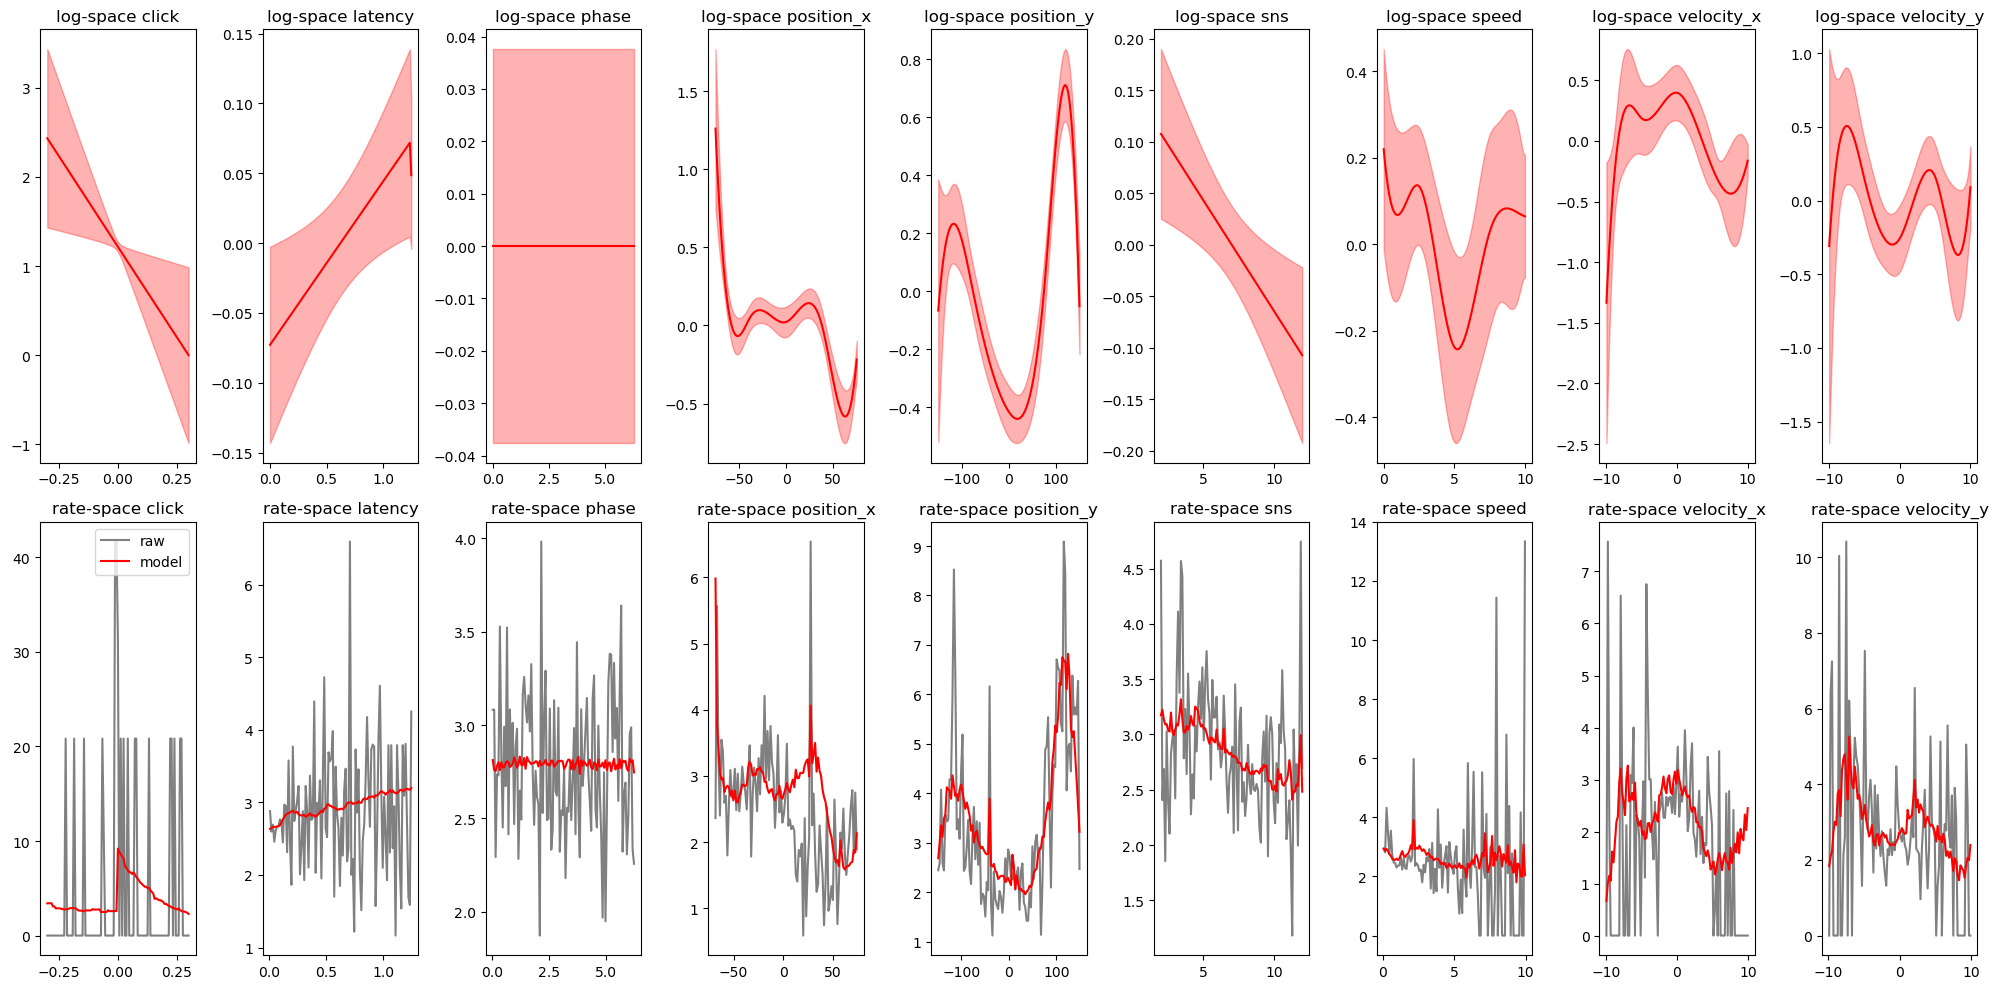

In [18]:

plt.figure(figsize=(20,10))
plt.title('Tuning functions for neuron %s'%neuron_num)
nk = len(res['variable'])
for k in range(nk):

    # Plotting the tuning function for each variable
    plt.subplot(2,nk,k+1)
    plt.title('log-space %s'%res['variable'][k])
    x_kernel = res['x_kernel'][k].flatten()
    y_kernel = res['y_kernel'][k]
    ypCI_kernel = res['y_kernel_pCI'][k]
    ymCI_kernel = res['y_kernel_mCI'][k]
    print(x_kernel.shape, y_kernel.shape)
    plt.plot(x_kernel, y_kernel, color='r')
    plt.fill_between(x_kernel, ymCI_kernel, ypCI_kernel, color='r', alpha=0.3)


    plt.subplot(2,nk,k+nk+1)
    plt.title('rate-space %s'%res['variable'][k])
    x_firing = res['x_rate_Hz'][k][0].flatten()
    y_firing_model = res['y_rate_Hz_model'][k].flatten()
    y_firing_raw = res['y_rate_Hz_raw'][k].flatten()
    print(x_firing.shape, y_firing_model.shape, y_firing_raw.shape)
    plt.plot(x_firing, y_firing_raw, color='grey',label='raw')
    plt.plot(x_firing, y_firing_model, color='r',label='model')

    if k == 0:
        plt.legend()
    plt.tight_layout()
#plt.savefig(os.path.join(save_dir, f'{neuron_num}_tuning.png'))
plt.show()
